# LC3 DATA ANALYSIS

### Load libraries and data

In [1]:
# Libraries for general data management
import pandas as pd
import numpy  as np

In [2]:
# Libraries for creating and validating models
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import mean_squared_error
from sklearn.model_selection import LeaveOneOut, cross_val_predict

In [3]:
# Libraries for data visualization
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches

In [4]:
# Input file path (can be also an excel)
DATA_PATH = './data/data_merged.ods'

In [5]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html

# Read data skipping the first row and considering also '-' as NaN
data = pd.read_excel(DATA_PATH, skiprows=[0], na_values=['-'])

In [6]:
# We rename some columns for having an easier reference
data.rename(columns = {'Calcined kaolinite content (%)':'Kaolinite_content'}, inplace = True)
data.rename(columns = {'Dv,50 (µm)':'Dv50'                                 }, inplace = True)
data.rename(columns = {'BET Specific surface (m2/g)':'BET_specific_surface'}, inplace = True)

data.rename(columns = {'STD'  : 'STD_1D'}, inplace = True)
data.rename(columns = {'STD.1': 'STD_3D'}, inplace = True)
data.rename(columns = {'STD.2': 'STD_7D'}, inplace = True)
data.rename(columns = {'STD.3':'STD_28D'}, inplace = True)
data.rename(columns = {'STD.4':'STD_90D'}, inplace = True)

# Sorting allows us to plot functions more easily
data = data.sort_values('Kaolinite_content')

# Get useful dataframe information
#data               # Get data
#data.describe()    # Get data general information
#data.columns       # Get data features names
#data.corr()        # Get correlation matrix

### Visualize data

In [7]:
# Take kaolinite content
x = data['Kaolinite_content'].values # (Pandas dataframe).values = numpy array

# Take compression strengths
y1  = data[ "1D"].values
y3  = data[ "3D"].values
y7  = data[ "7D"].values
y28 = data["28D"].values
y90 = data["90D"].values

# Measures at 90 days have missing values (4 in total)
x90 =   x[np.logical_not(np.isnan(y90))]
y90 = y90[np.logical_not(np.isnan(y90))]

# Take standard deviations
#z1  = data[ "STD_1D"].values
#z3  = data[ "STD_3D"].values
#z7  = data[ "STD_7D"].values
#z28 = data["STD_28D"].values
#z90 = data["STD_90D"].values

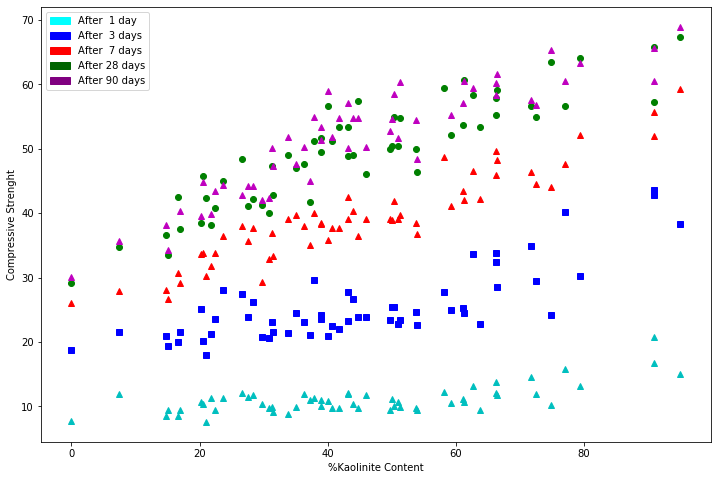

In [8]:
# Show points using matplotlib.pyplot library
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(x,y1,'c^',x,y3,'bs',x,y7,'r^',x,y28,'go', x90,y90,'m^')
plt.xlabel('%Kaolinite Content')
plt.ylabel('Compressive Strenght')

d1_patch  = mpatches.Patch(color='cyan',      label='After  1 day')
d3_patch  = mpatches.Patch(color='blue',      label='After  3 days')
d7_patch  = mpatches.Patch(color='red',       label='After  7 days')
d28_patch = mpatches.Patch(color='darkgreen', label='After 28 days')
d90_patch = mpatches.Patch(color='purple',    label='After 90 days')
plt.legend(handles=[d1_patch,d3_patch,d7_patch,d28_patch,d90_patch])

plt.show()

**First sight analysis:**

* **CS Day 1:** Almost constant, it curves from kaolinite content 50%, try degree two feature expansion.
* **CS Day 3:** Sparse points, we need to add another feature and maybe try also feature expansion.
* **CS Day 7:** The straight line is quite clear, we can try adding another feature for avoiding sparsification.
* **CS Day 28:** Straight line until 40% kaolinite content, then it curves. Feature expansion is needed as well as another feature for reducing sparsification.
* **CS Day 90:** Totally analogous than the day 28 data.


**Second sight analysis:**
* Maybe it would be interesting to have a predictor of the compression strength at 90 days (at time=infinity) knowing the compression strength before.
* In feature augmentation never go further than degree two, the curve is clearly always increasing.
* When having models involving only one or two features it's going to be important to plot for checking correctness.
* We have to search also mathematical measurements for the correctness of our models.

### Data correlation analysis

We have measures of 21 features/properties of the clays. Which are the (cor)relations among them? Which are the most important for predicting the compression strength? Are there redundancies? 

The first analysis for answering that question is going to be given by analyzing the correlations.

In [9]:
# Function to hightlight high correlated cells in red
def highlight_high_correlations(cell):
    return 'background-color: %s' % ('red' if (cell != 1 and abs(cell) > CORRELATION_THRESHOLD) else 'white')

In [10]:
# Correlation between clays properties themselves
CORRELATION_THRESHOLD = 0.6

corr_matrix = data.corr()[10:].iloc[:, 10:]
corr_matrix.style.applymap(highlight_high_correlations)

,Kaolinite_content,Dv50,D10,D90,Span (-),BET_specific_surface,SiO2,Al2O3,Fe2O3,CaO,MgO,SO3,Na2O,K2O,TiO2,P2O5,MnO,Others,LOI
Kaolinite_content,1.000000,-0.193500,-0.305015,-0.244189,0.084792,0.091568,-0.662171,0.916967,-0.253895,-0.201540,-0.334250,0.015434,-0.197303,-0.411571,0.415086,-0.036408,0.318173,0.023426,0.232083
Dv50,-0.193500,1.000000,0.451829,0.776255,0.119163,-0.015583,0.287292,-0.242921,-0.189271,0.042118,0.052258,0.077456,-0.096222,0.074709,-0.006009,0.385650,0.255514,-0.084343,-0.230361
D10,-0.305015,0.451829,1.000000,-0.035547,-0.436280,-0.404479,0.382222,-0.145179,-0.431953,-0.214363,-0.187739,0.225985,0.012912,0.618675,-0.589368,0.378885,-0.771972,-0.200548,-0.064193
D90,-0.244189,0.776255,-0.035547,1.000000,0.736569,-0.089815,0.193764,-0.340139,-0.028480,0.342000,0.365395,0.975371,-0.132507,0.047146,-0.043585,0.138796,-0.142464,-0.011756,-0.171109
Span (-),0.084792,0.119163,-0.436280,0.736569,1.000000,0.101806,-0.072553,-0.042011,0.082441,0.072997,-0.075898,0.033117,-0.094787,-0.161342,0.197525,-0.029135,0.115944,-0.168370,-0.043502
BET_specific_surface,0.091568,-0.015583,-0.404479,-0.089815,0.101806,1.000000,-0.421059,0.052440,0.619421,-0.100527,0.147891,-0.151082,-0.016290,-0.183056,0.099011,-0.142684,0.643980,-0.342051,0.152745
SiO2,-0.662171,0.287292,0.382222,0.193764,-0.072553,-0.421059,1.000000,-0.725183,-0.364198,-0.108063,-0.181542,-0.208559,-0.144506,0.130411,-0.410854,-0.038594,-0.305488,0.057821,-0.390461
Al2O3,0.916967,-0.242921,-0.145179,-0.340139,-0.042011,0.052440,-0.725183,1.000000,-0.282481,-0.211962,-0.286575,-0.169586,-0.213801,-0.315134,0.369314,-0.051612,0.372933,-0.036482,0.308423
Fe2O3,-0.253895,-0.189271,-0.431953,-0.028480,0.082441,0.619421,-0.364198,-0.282481,1.000000,0.004174,0.231275,0.008352,0.158245,-0.114540,0.208177,0.095215,0.104339,-0.108749,-0.060084
CaO,-0.201540,0.042118,-0.214363,0.342000,0.072997,-0.100527,-0.108063,-0.211962,0.004174,1.000000,0.569413,0.625109,0.496111,-0.086462,-0.304487,-0.135553,-0.081563,0.128110,0.067826


In [11]:
# Correlation between Compression Strength measurements and clays properties
CORRELATION_THRESHOLD = 0.5

corr_matrix = data.corr()[10:].iloc[:, [0,2,4,6,8]]
corr_matrix.style.applymap(highlight_high_correlations)

,1D,3D,7D,28D,90D
Kaolinite_content,0.672115,0.772572,0.931003,0.898135,0.910680
Dv50,-0.111246,-0.011320,-0.116061,-0.146193,-0.152193
D10,-0.274278,-0.351558,-0.296297,-0.287737,-0.290692
D90,-0.225330,-0.169381,-0.147715,-0.131897,-0.141472
Span (-),-0.008618,0.096408,0.176071,0.178734,0.099044
BET_specific_surface,-0.077832,-0.032558,0.083831,0.108786,0.198791
SiO2,-0.430950,-0.443933,-0.563664,-0.579837,-0.635442
Al2O3,0.614406,0.705345,0.834569,0.809226,0.845753
Fe2O3,-0.268702,-0.284461,-0.265054,-0.259344,-0.242389
CaO,-0.171936,-0.143753,-0.217687,-0.181013,-0.136114


In [12]:
# Correlation between standard deviations of measurements and clays properties
CORRELATION_THRESHOLD = 0.2

corr_matrix = data.corr()[10:].iloc[:, [1,3,5,7,9]]
corr_matrix.style.applymap(highlight_high_correlations)

,STD_1D,STD_3D,STD_7D,STD_28D,STD_90D
Kaolinite_content,0.082912,0.444221,0.177116,0.328974,0.194653
Dv50,-0.118125,-0.129720,-0.113932,-0.185816,-0.105022
D10,-0.159055,-0.401368,-0.215840,-0.224444,-0.245231
D90,-0.018398,-0.070994,-0.032689,-0.082954,0.184129
Span (-),0.020704,0.055594,0.044010,0.022846,0.143911
BET_specific_surface,-0.345532,0.010624,-0.092784,0.131376,-0.059141
SiO2,0.006149,-0.302855,-0.086754,-0.322744,-0.080277
Al2O3,0.029920,0.394946,0.248389,0.322680,0.106657
Fe2O3,-0.137893,-0.100728,-0.108874,0.004947,0.019647
CaO,0.140246,0.012872,-0.146547,-0.101726,0.134408


**First sight analysis:**

* Several important correlations between features, be aware of this when chosing features for our model to avoid redundancy.
* Compression strength can be predicted quite good with only the Kaolinite content, the relation is clear.
* At first sight there is no clear evidence of any feature being behind the standard deviation/variability of lc3.

# COMPRESSION STRENGTH (CS)

### Feature selection

In [13]:
# TODO: Be sure of r² as the best way for determining which features to use for linear regression 
# TODO: Go to Andrés' notebook and take his function for getting the features with the biggest r²
# TODO: Read https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/
#       Read https://machinelearningmastery.com/an-introduction-to-feature-selection/
#       Read A TRAP WHEN SELECTING FEATURES in https://machinelearningmastery.com/an-introduction-to-feature-selection/ 
#       Read https://en.wikipedia.org/wiki/Feature_selection
#       Read https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/

### Linear regression models

We have seen that the kaolinite content is the most predictive feature that we have. We are going to start creating simple linear regression models and then, following the appreciations obtained by visualizing the data, we are going to create non-linear models based on the kaolinite content for better fitting the data distribution as well as models with more features for avoiding data sparsification.

Two metrics are going to be extremely important here:
* **R square:** Is giving us a measurement of how good is our model (the closer to 1.0 the better). 
* **Validation score:** Is going to let us control overfitting. Improving R² means nothing if validation is worse. We'll use mean squared error with Leave One Out cross validation to estimate it.

In [48]:
# TODO: Remove outlier in y1 data?
# TODO: Idea for the report, removing pesimist outliers is not a good idea in our project!
# TODO: Add OPC compression strength values for reference

#### Linear models based on the kaolinite content

In [33]:
# Create, estimate, validate and show the model
def leave_one_out_validation(X, y, model=LinearRegression()):
    # Train the model
    model.fit(X, y) 
    
    # Plot the results
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(X, np.dot(X,model.coef_) + model.intercept_,'r-')
    ax.scatter(X, y, edgecolors=(0, 0, 0))
    ax.set_xlabel('% Kaolinite content')
    ax.set_ylabel('Compressive strength')
    plt.show()
    
    # Get the list of predictions obtained while validating
    predicted = cross_val_predict(model, X, y, cv=LeaveOneOut())
    
    # Model and metrics
    print('f(x) = {0} + {1}*x'.format(model.intercept_, model.coef_[0]))
    print()
    print("MSE: {}".format(mean_squared_error(y, predicted)))
    print("R^2: {}".format(model.score(X,y)))

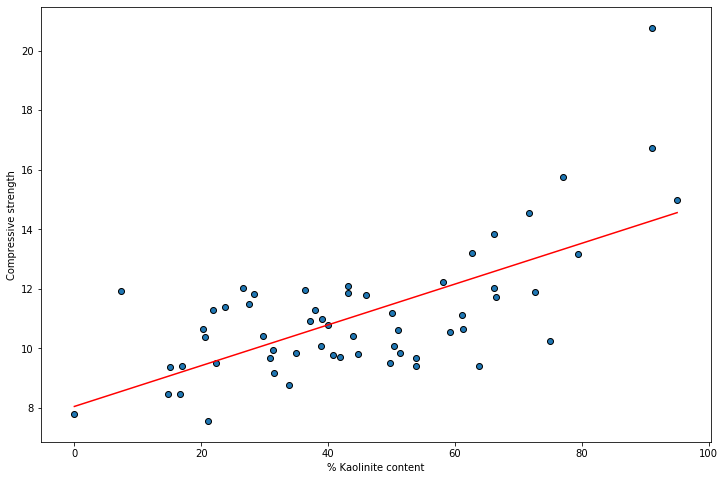

f(x) = 8.051988963462057 + 0.06849127373216797*x

MSE: 2.9669319608857885
R^2: 0.4517382370956148


In [27]:
leave_one_out_validation(x.reshape(-1,1), y1)

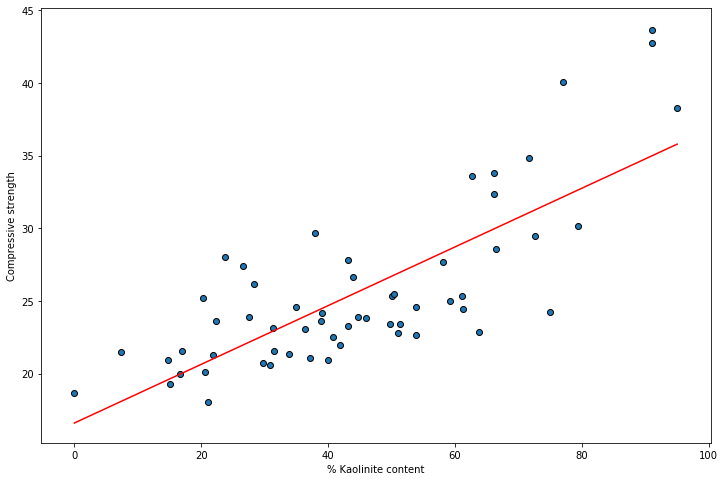

f(x) = 16.60572385051616 + 0.20204648367205708*x

MSE: 14.1087782401468
R^2: 0.5968668242735541


In [28]:
leave_one_out_validation(x.reshape(-1,1), y3)

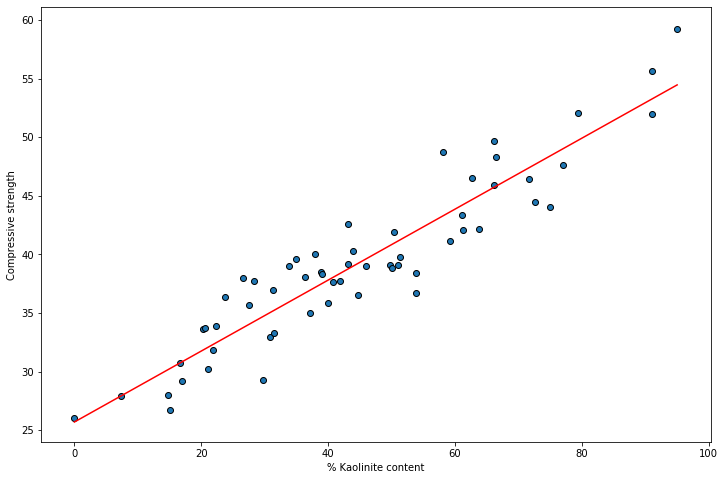

f(x) = 25.69373622589084 + 0.3027385109008508*x

MSE: 7.039998611976816
R^2: 0.8667669637129656


In [29]:
leave_one_out_validation(x.reshape(-1,1), y7)

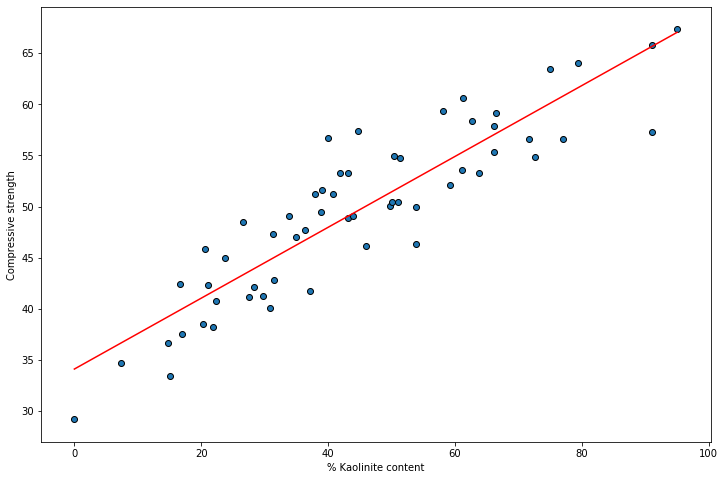

f(x) = 34.10169654021773 + 0.34673217282153324*x

MSE: 14.414074644925593
R^2: 0.8066458956382334


In [30]:
leave_one_out_validation(x.reshape(-1,1), y28)

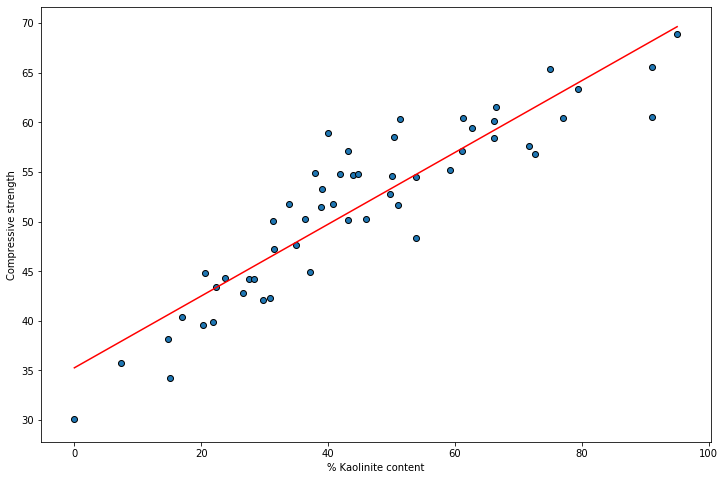

f(x) = 35.26614365142822 + 0.3618699446602336*x

MSE: 13.541515282787257
R^2: 0.8293385347504323


In [31]:
leave_one_out_validation(x90.reshape(-1,1), y90)

**First sight analysis:**

* There is few more we can improve at the 7th day using only the kaolinite content, data distribution is quite a straight line.
* For 1st and 3rd day the problem is more the sparsification of the points than the lack of expresivity of the model.
* For 28th and 90th day until 40% of kaolinite content the compression strength increases linearly and then estabilizes. Makes sense a non-linear model.
* It doesn't make sense in any model a degree 3 regression model, compression strength increases with kaolinite content.

#### Non-linear models based on the kaolinite content

In [34]:
# x_2 = Kaolinite content, (Kaolinite content)^2
x_2   = np.array([x, x*x]).T
x90_2 = np.array([x90,x90*x90]).T 

In [42]:
# Same function than before but adapted for degree two case
def leave_one_out_validation(X, y, model=LinearRegression()):
    # Train and show the model
    model.fit(X, y) 
    
    # This could be generalized but degree n >= 3 leads to overfitting!
    print('f(x) = {0} + {1}*x + {2}*x^2'.format(model.intercept_, model.coef_[0], model.coef_[1]))
        
    # Get the list of predictions obtained while validating
    predicted = cross_val_predict(model, X, y, cv=LeaveOneOut())
    
    # Plot the results
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(X[:,0], np.dot(X,model.coef_) + model.intercept_,'r-')
    ax.scatter(X[:,0], y, edgecolors=(0, 0, 0))
    ax.set_xlabel('% Kaolinite content')
    ax.set_ylabel('Compressive strength')
    plt.show()
    
    # Metrics for the model
    print("MSE: {}".format(mean_squared_error(y, predicted)))
    print("R^2: {}".format(model.score(X,y)))

f(x) = 10.478219444077304 + -0.05802811082833178*x + 0.0013110628728686142*x^2


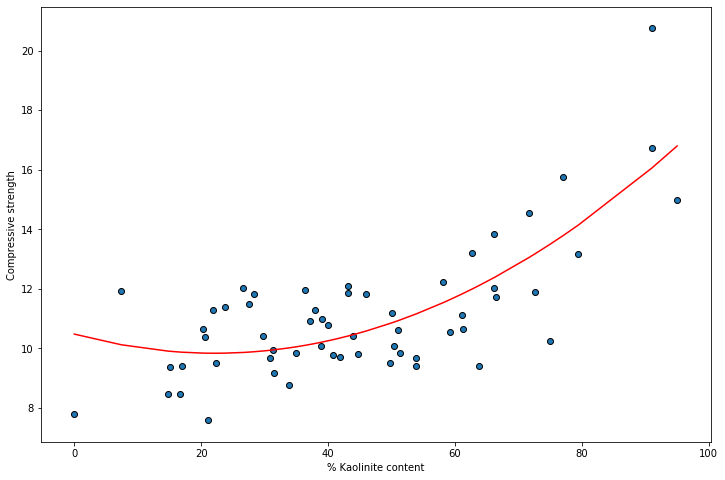

MSE: 2.6221974455456207
R^2: 0.564069137329487


In [43]:
leave_one_out_validation(x_2, y1)

f(x) = 22.316531996062583 + -0.09575207161375508*x + 0.003085951064221629*x^2


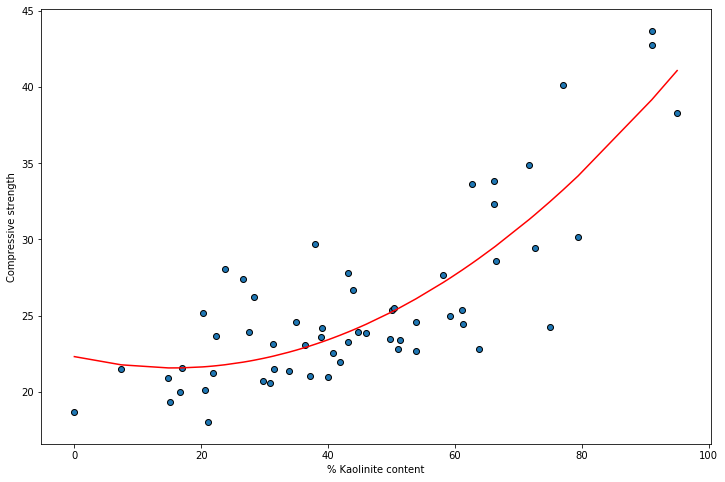

MSE: 11.202749432292585
R^2: 0.69135745568661


In [44]:
leave_one_out_validation(x_2, y3)

f(x) = 26.66552702242966 + 0.25206303943102093*x + 0.0005251268763280832*x^2


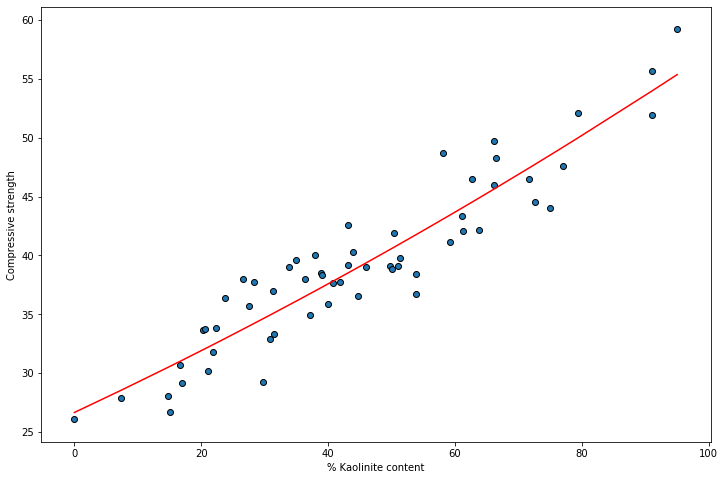

MSE: 7.213031472294101
R^2: 0.8685367928317549


In [45]:
leave_one_out_validation(x_2, y7)

f(x) = 30.1573044441616 + 0.5524183450320862*x + -0.0021314323080568326*x^2


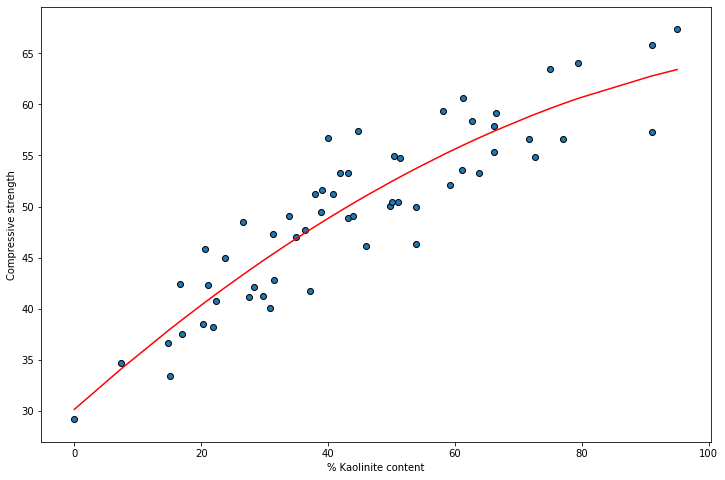

MSE: 13.38951338501839
R^2: 0.8273317550793433


In [46]:
leave_one_out_validation(x_2, y28)

f(x) = 29.394944062897192 + 0.6625193043103382*x + -0.0030766912379724103*x^2


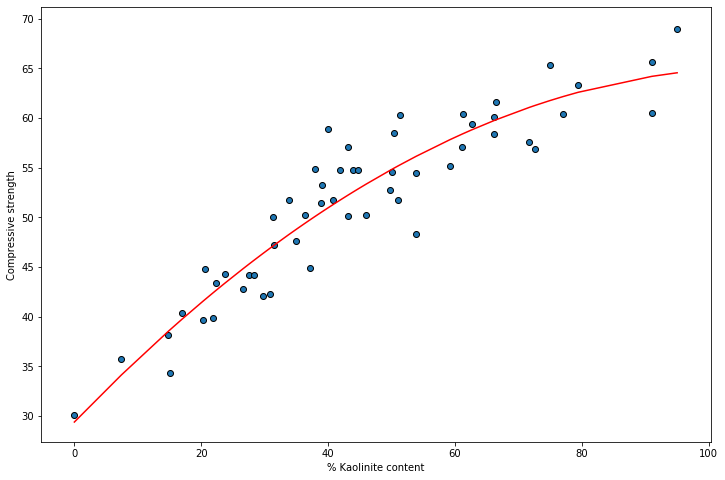

MSE: 10.545891820955662
R^2: 0.8717081451424198


In [47]:
leave_one_out_validation(x90_2, y90)

**First sight analysis:**

* Expected results, better models obtained for 28th and 90th day compression strength obtained.
* We might be experiencing overfitting with this model for 1st and 3rd day measurements because we're not increasing the compressive strength with the increase of calonita for small contents.

#### Linear regression models based on the kaolinite content and other features

In [53]:
# TODO!

### References:

* How to deal with small datasets:\
https://medium.com/rants-on-machine-learning/what-to-do-with-small-data-d253254d1a89

* Feature engineering: \
https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/

* Feature selection: \
https://en.wikipedia.org/wiki/Feature_selection \
https://machinelearningmastery.com/an-introduction-to-feature-selection/ \
https://machinelearningmastery.com/feature-selection-machine-learning-python/ \
https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/ \
https://machinelearningmastery.com/calculate-feature-importance-with-python/
